In [19]:
pip install statsmodels

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [21]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


In [22]:
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.tail(5)

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [23]:
#EDA
df.isnull().sum()

,0
Month,0
Passengers,0


Text(0, 0.5, 'Passengers')

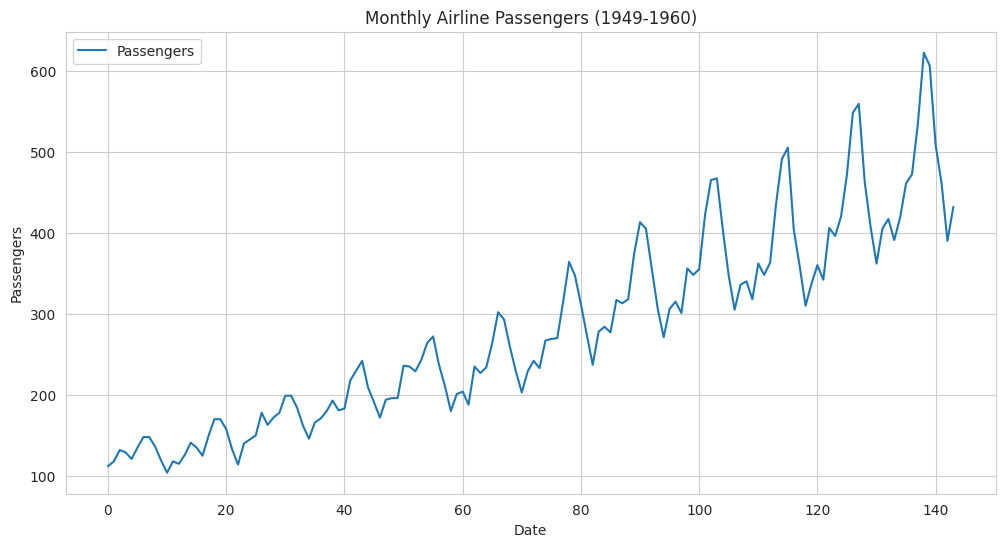

In [24]:
df.plot()
plt.title("Monthly Airline Passengers (1949-1960)")
plt.xlabel("Date")
plt.ylabel("Passengers")

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


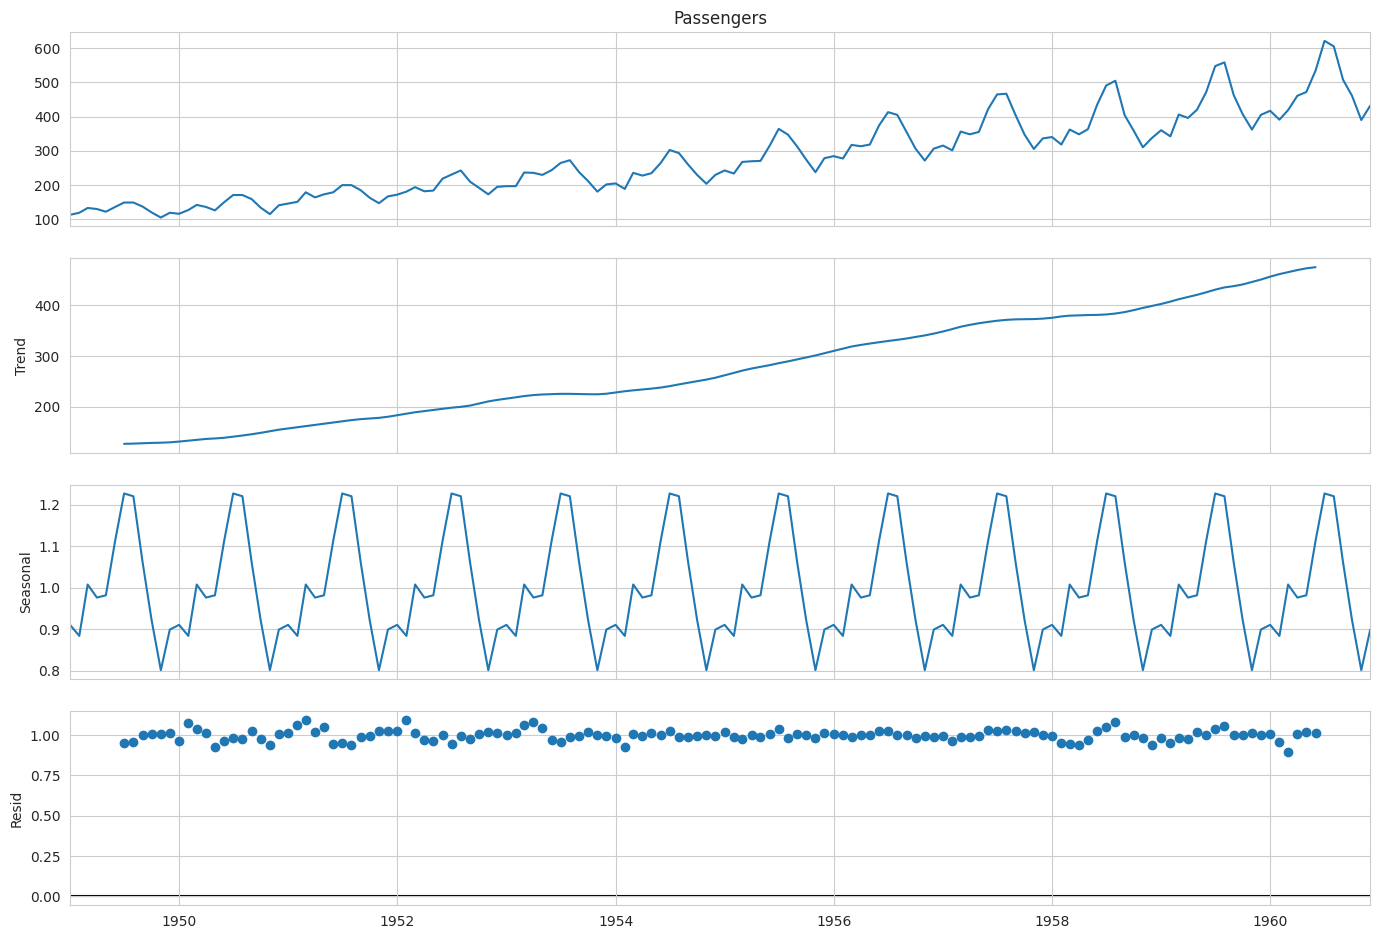

In [26]:
#convert datatype
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

**Initial Observation:** The plot clearly shows two strong patterns:
1.  **Upward Trend:** The number of passengers is increasing over time.
2.  **Seasonality:** There is a clear, repeating annual pattern (peaks and troughs within each year).
3.  **Increasing Variance:** The seasonal fluctuations appear to be getting larger over time.

**Stationary**
A stationary time series is one where the statistical properties do not change over time.
That means:

Mean (average) is constant

Variance (spread of data) is constant

Autocovariance (relationship with its past values) depends only on the lag, not the actual time.


**Why stationary is important for timeseries data:**
Many time series models (like ARIMA) assume stationarity because their equations are based on the idea that the underlying process does not change over time.
If the series is non-stationary (trend or changing variance), predictions will be unreliable because the model tries to fit moving patterns.

**Augmented Dickey-Fuller (ADF)** test:
The Augmented Dickey-Fuller (ADF) Test is a common statistical test.
Null Hypothesis ($H_0$): The series is non-stationary.
Alternative Hypothesis ($H_1$): The series is stationary.
We want to reject the null hypothesis. To do this, we need the p-value from the test to be less than a significance level (e.g., 0.05).

Think of the ADF test as asking the question: "Does this time series have a trend or other patterns that make it non-stationary?"
Here's what each part means:

Test Statistic: This is a number calculated from your data. It's the main result of the test.
p-value: This is the most important number for a beginner. It tells you how likely it is that you would get your results if the time series were actually stationary (which is the opposite of what we usually want).
If the p-value is small (usually less than 0.05): This means it's very unlikely to get these results if the series were stationary. So, you can confidently say, "Okay, this series is not stationary."
If the p-value is large (like yours, 0.99): This means it's quite likely to get these results even if the series were stationary. So, you cannot confidently say it's not stationary. In other words, you fail to reject the null hypothesis, which is that the series is non-stationary.
Lags Used: This is the number of past data points the test looked at to help make its decision.
Number of Observations Used: This is how many data points from your time series were actually used in the test calculation.

Critical Value (1%), (5%), (10%): These are threshold values. If your "Test Statistic" is smaller than one of these critical values (more negative), you would reject the null hypothesis at that confidence level. For example, if your Test Statistic was less than -3.48 (the 1% critical value), you'd be very confident (99%) that the series is stationary. Why do we use it?

We use the ADF test (and look at the p-value) because many powerful time series forecasting models, like ARIMA, assume that the data they are working with is stationary. If your data is not stationary, these models might not work well or give you inaccurate forecasts. The ADF test gives us a statistical way to check this assumption before we build our models.

In your case, the high p-value (0.99) tells us that your 'Passengers' data is non-stationary, just as we suspected from looking at the plot earlier. This confirms that you need to perform transformations (like differencing) to make it stationary before building an ARIMA model.

In [27]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


**Result**: The p-value is 0.99, which is much greater than 0.05. Therefore, we fail to reject the null hypothesis. Our data is officially non-stationary, and we need to transform it.

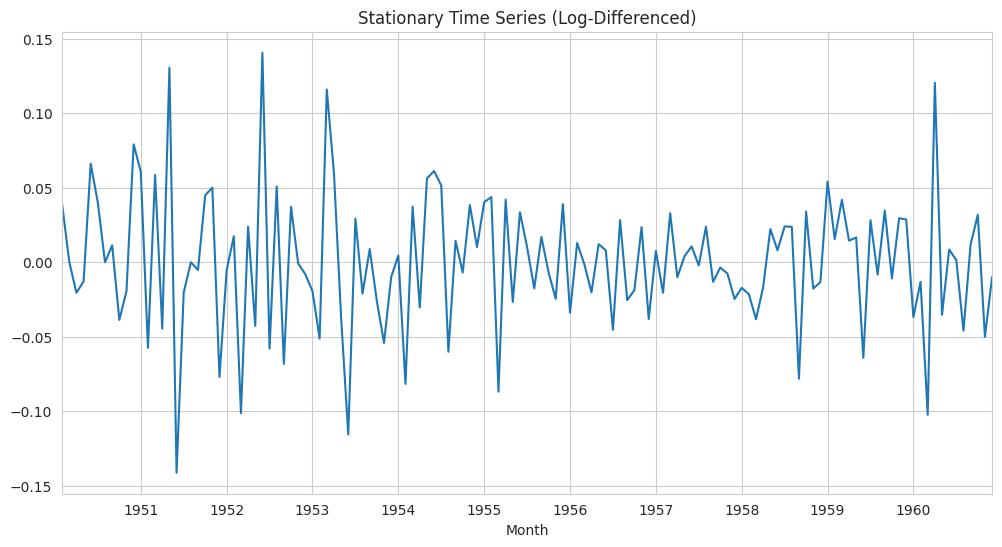

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64


In [28]:
#We'll use two common techniques: log transformation to stabilize the variance and differencing to remove the trend.
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().diff(12).dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

**Result**: The new p-value is 0.07, which is greater than 0.05. We can not reject the null hypothesis. Our series is  not stationary and ready for modeling!



ACF (Autocorrelation Function): Measures the correlation between a time series and its lagged versions (e.g., how much the value today is correlated with the value yesterday, the day before, etc.). The plot shows spikes at lags where there is significant autocorrelation. PACF (Partial Autocorrelation Function): Measures the direct correlation between a time series and its lagged versions, after removing the effects of the intermediate lags. It helps identify the direct relationship between the current value and a specific lagged value. These plots help us determine the p and q parameters for the ARIMA model:


p (AR term): Suggested by the number of significant lags in the PACF plot where the spikes "cut off" or drop to near zero. q (MA term): Suggested by the number of significant lags in the ACF plot where the spikes "cut off".


Log transform → fixed variance instability (handled multiplicative seasonality).

Differencing after log → removed the upward trend and seasonality, making the series stationary.

With p-value < 0.05, we can confidently proceed with ARIMA modeling.

Log transformation compresses larger values more than smaller ones.

Before log: big swings in later years overshadow early years.

After log: variance becomes more stable (seasonal swings look proportional instead of growing).
So: Log stabilizes variance but does not remove the trend.

Even after logging, the series still has a trend (an upward slope).

Stationarity requires a constant mean. A trend violates that.

👉 Differencing removes the trend

On log data, differencing is like looking at percentage changes (growth rates) instead of absolute levels.

This transforms the data into a series that “wiggles” around a constant mean.

So: Differencing removes trend (and sometimes seasonality) after log stabilizes variance.

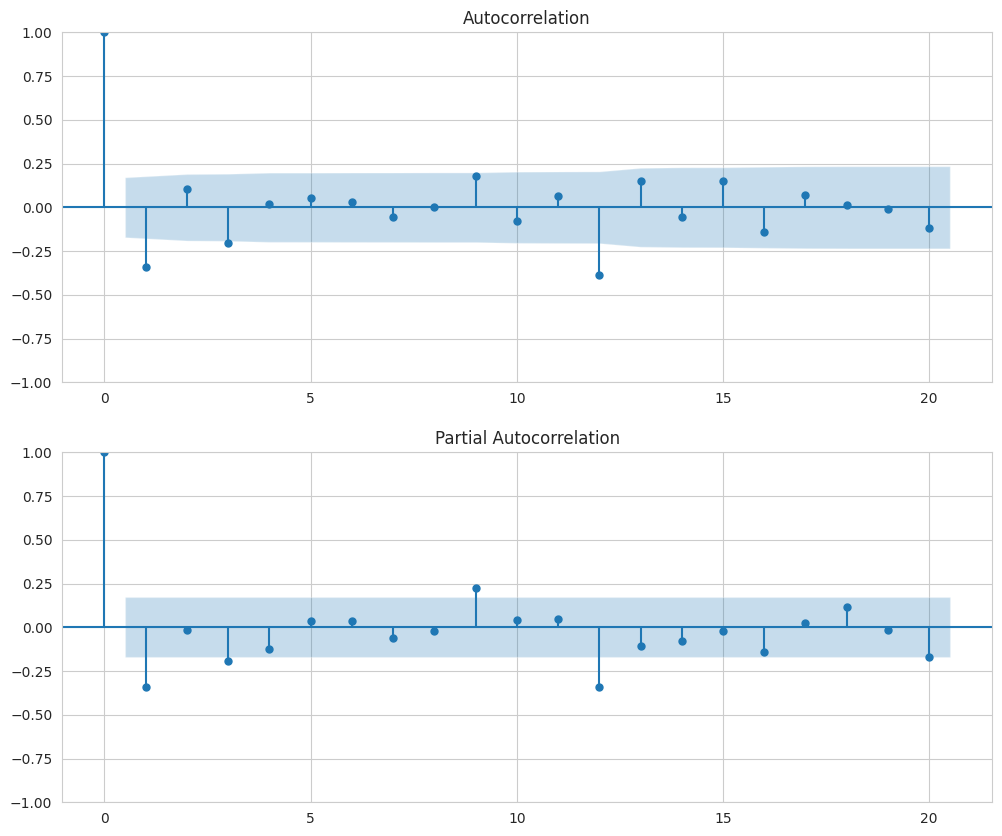

In [29]:
#calculating p,q value for arima value
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

Interpretation:

PACF Plot: Cuts off sharply after lag 1. This suggests p=1.
ACF Plot: Also seems to cut off after lag 1. This suggests q=1. Based on this, a good starting point for our model is ARIMA(1, 1, 1).

## **Theoretical Concept: ARIMA**
**AutoRegressive Integrated Moving Average (ARIMA)** models are a class of statistical models for analyzing and forecasting time series data. An ARIMA model is characterized by three parameters:

- **AR (Autoregressive) - p:** The number of lag observations included in the model. This term captures the relationship between the current observation and its past values.
- **I (Integrated) - d:** The number of times that the raw observations are differenced. This is done to make the time series stationary.
- **MA (Moving Average) - q:** The size of the moving average window. This term captures the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The model is typically denoted as **ARIMA(p, d, q)**.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


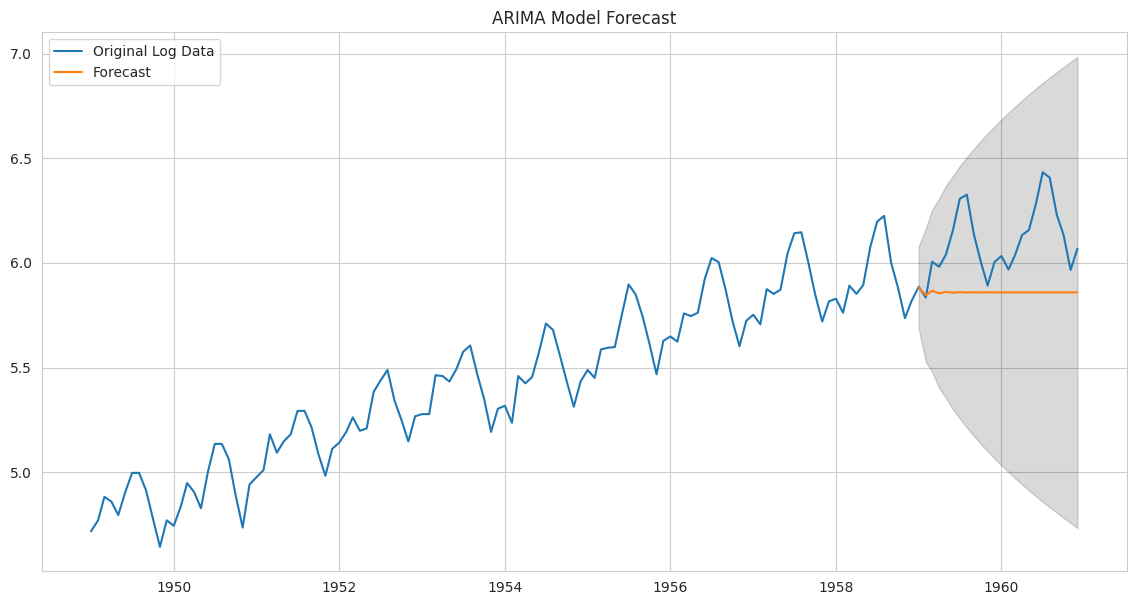

In [30]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

ARIMA Result: The model captures the overall trend but completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


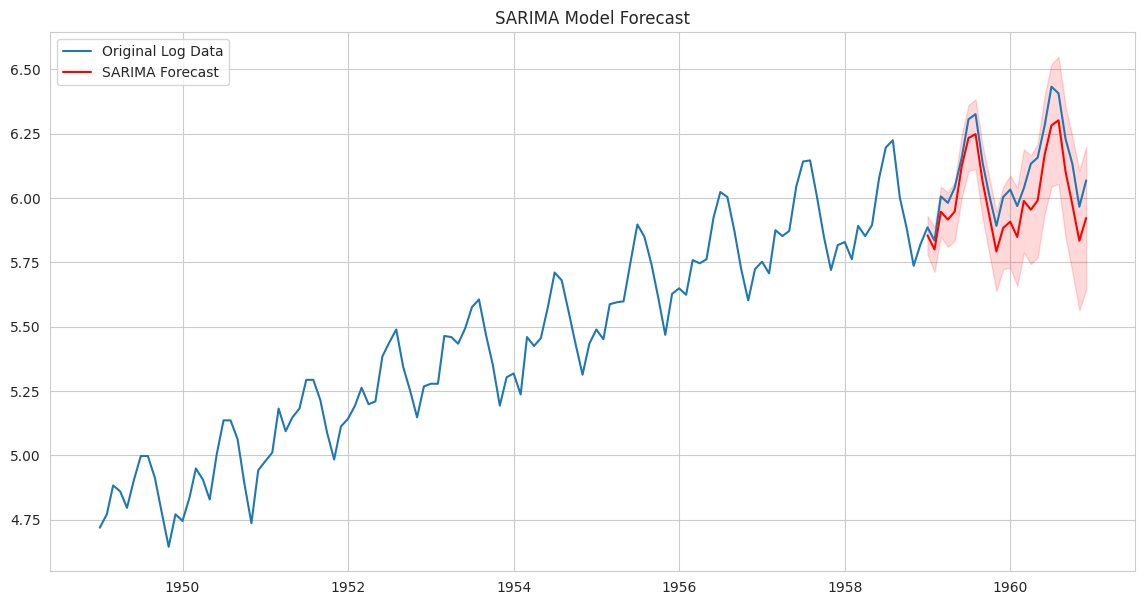

In [31]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**Insights**:
after comparing the both model , we can say the prediction by a sarima model is much more accurate as compare to arima model as arima model donot capture seasonal trend that leads to a flat  horizontal predicted line at end